This notebook is a tempate to work on an illustration of transfer learning. 
It should use:
- a pre-trained Model from Keras (Xception at first)
- a dataset of images of casting products (impellers for submersible pumps), 
some of which have a defect (available in `casting_512x512.zip` 
or on [Kaggle](https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product))

Add a simple classification layer to the pre-trained model, and train it with 
the pictures.
When this works, try different tweaks such as different models, data augmentation, 
etc. 

The code can be adapted from: 
- Keras tutorial https://keras.io/guides/transfer_learning/
- Kaggle tutorial https://www.kaggle.com/code/digantdixit/transfer-learning-cnn-for-beginners

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow, os, keras

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import Xception, MobileNet, ResNet50


from keras.preprocessing.image import img_to_array, array_to_img
import time

2024-11-22 12:04:53.953512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732273493.970178  122310 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732273493.974832  122310 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 12:04:53.991450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.


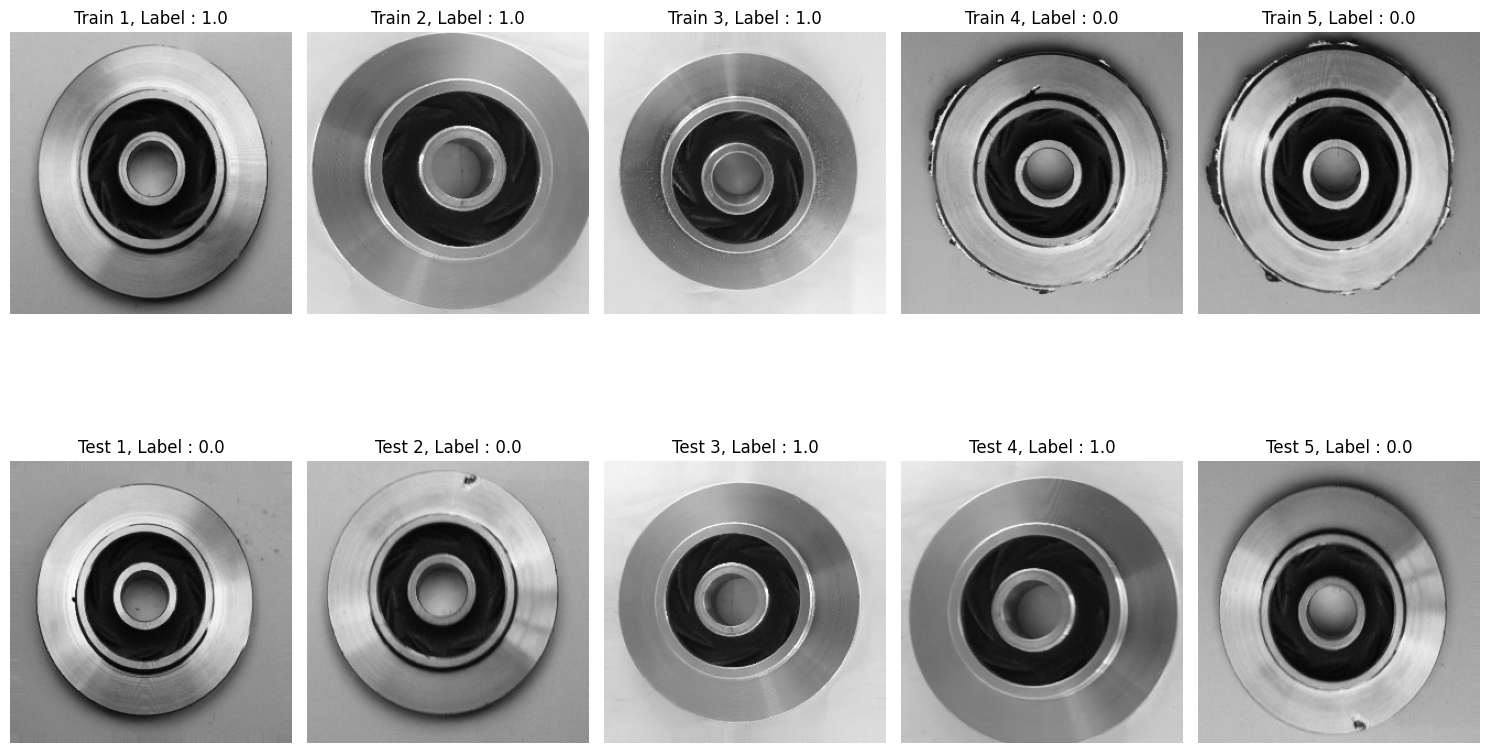

{'def_front': 0, 'ok_front': 1}
{'def_front': 0, 'ok_front': 1}


In [2]:
# Load your dataset from the directory `casting_512x512`
# by using keras.preprocessing.image.ImageDataGenerator
# check that you have 2 classes
# think about rescaling and train/test splitting
# plot a few pictures to see what you deal with

train_data_gen = image.ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train = train_data_gen.flow_from_directory(
    directory="casting_512x512/",
    target_size=(256, 256),
    batch_size=32,
    class_mode="binary",
    subset="training",
)
test = train_data_gen.flow_from_directory(
    directory="casting_512x512/",
    target_size=(256, 256),
    batch_size=32,
    class_mode="binary",
    subset="validation",
)

train_images, train_labels = next(train)  # Get a batch of 32 images and their labels
test_images, test_labels = next(test)  # Get a batch of 32 images and their labels

fig, axes = plt.subplots(2, 5, figsize=(15, 10))

# Plot 5 training images
for i in range(5):
    axes[0, i].imshow(train_images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Train {i+1}, Label : {train_labels[i]}")

# Plot 5 testing images
for i in range(5):
    axes[1, i].imshow(test_images[i]) 
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Test {i+1}, Label : {test_labels[i]}")

plt.tight_layout()
plt.show()

print(train.class_indices)
print(test.class_indices)

In [3]:
xcept = Xception(input_shape=(256, 256, 3), include_top=False, weights="imagenet")

I0000 00:00:1732273496.520075  122310 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10174 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
# Use the code from  Keras transfer learning tutorial
# https://keras.io/guides/transfer_learning/
# Adapt it to your case
# Freeze weights
# Replace last layer with a 2-class classifier
# Compile it

# Adapted code from Keras transfer learning tutorial
xcept.trainable = False
inputs = keras.Input(shape=(256, 256, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = xcept(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [5]:
# print model summary
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

None


In [6]:
# Fit your model for a few epochs using 'train' data and 'test' validation data
model.fit(
    train,
    epochs=10,
    steps_per_epoch=15,
    validation_data=test,
    validation_steps=len(test),
)

Epoch 1/10


/home/rbonhomme001/Documents/Cours/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732273501.337856  122433 service.cc:148] XLA service 0x7f4668004a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732273501.337881  122433 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-22 12:05:01.448088: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732273502.018650  122433 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/15 ━━━━━━━━━━━━━━━━━━━━ 2:31 11s/step - accuracy: 0.5000 - loss: 0.7055

I0000 00:00:1732273508.966709  122433 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 806ms/step - accuracy: 0.6143 - loss: 0.6596 - val_accuracy: 0.7143 - val_loss: 0.5901
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6888 - loss: 0.5571 - val_accuracy: 0.6332 - val_loss: 0.5385
Epoch 3/10
 3/15 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6094 - loss: 0.5964

/home/rbonhomme001/Documents/Cours/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6469 - loss: 0.5590 - val_accuracy: 0.6834 - val_loss: 0.5277
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.7245 - loss: 0.4816 - val_accuracy: 0.7529 - val_loss: 0.4864
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.7012 - loss: 0.4966 - val_accuracy: 0.7568 - val_loss: 0.4590
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7789 - loss: 0.4163 - val_accuracy: 0.7143 - val_loss: 0.4673
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6990 - loss: 0.4565 - val_accuracy: 0.7683 - val_loss: 0.4368
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.7802 - loss: 0.4085 - val_accuracy: 0.7568 - val_loss: 0.4129
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7913 - loss: 0.3396 - val_accuracy: 0.7568 - val_loss: 0.4106
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.7991 - loss: 0.3475 - val_accuracy: 0.7645 - val_lo

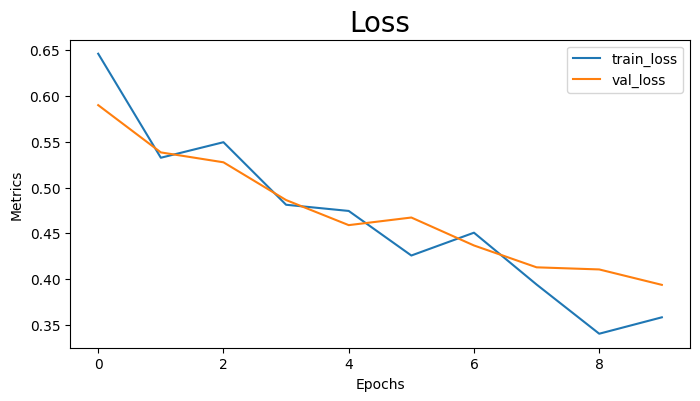

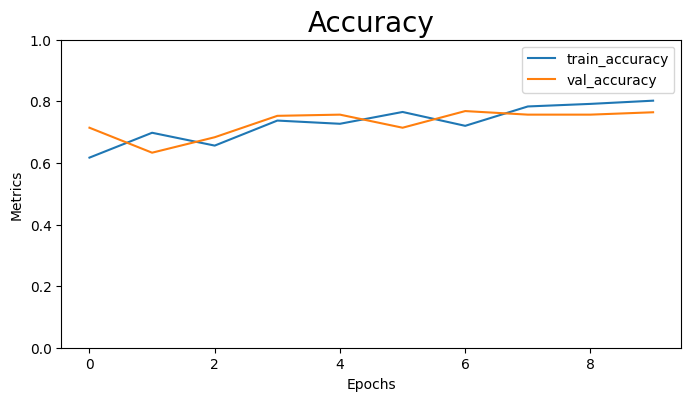

In [7]:
# plot loss and  accuracy as a function of epochs

# plot loss
plt.subplots(figsize=(8, 4))
X = range(1, 1 + len(model.history.epoch))
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title(r"Loss", fontsize=20)
plt.xlabel(r"Epochs")
plt.ylabel(r"Metrics")
plt.legend(labels=[r"train_loss", r"val_loss"])
plt.show()

# plot accuracy
plt.subplots(figsize=(8, 4))
plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history["val_accuracy"])
plt.title(r"Accuracy", fontsize=20)
plt.xlabel(r"Epochs")
plt.ylabel(r"Metrics")
plt.ylim(0, 1)
plt.legend(labels=[r"train_accuracy", r"val_accuracy"])
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step


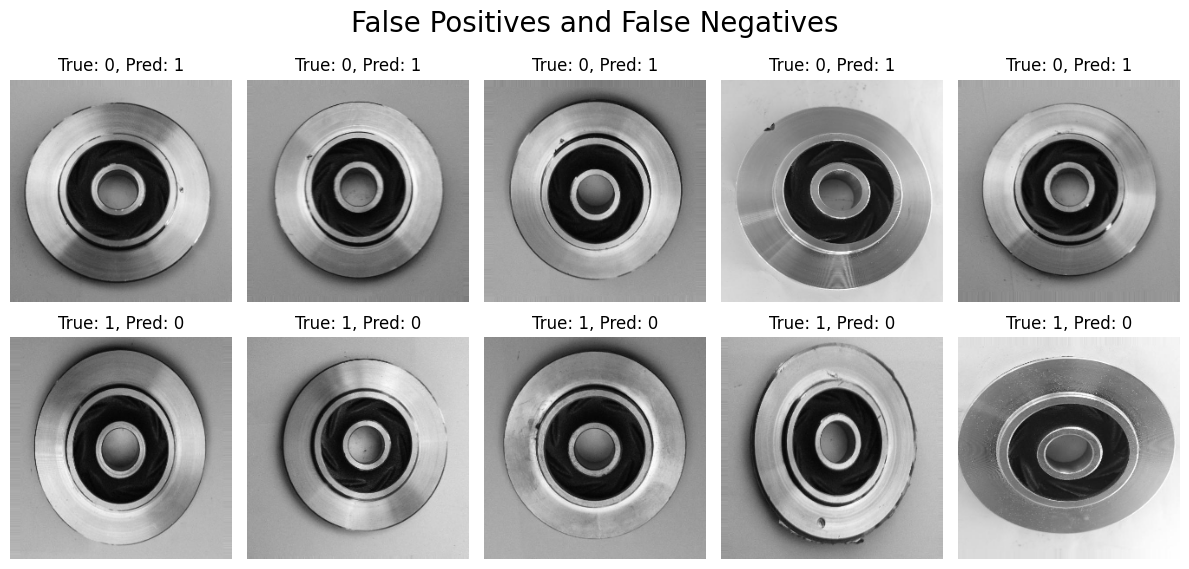

In [8]:
# plot the result of some predictions. Plot some false positives.

predictions = model.predict(test, steps=len(test))
true_labels = test.labels
threshold = 0.5 
num_to_plot = 5

# Get the predicted class labels (0 or 1)
predicted_labels = (predictions > threshold).astype(int)

# False Positives (True label is 0, predicted label is 1)
false_positives_0 = np.where((predicted_labels == 1) & (true_labels == 0))[0]

# False Negatives (True label is 1, predicted label is 0)
false_negatives_1 = np.where((predicted_labels == 0) & (true_labels == 1))[0]

plt.figure(figsize=(12, 6))

# Plot false positives (True 0, Pred 1)
for i in range(num_to_plot):
    idx = false_positives_0[i]
    img, _ = test[idx]
    img = img[i]
    plt.subplot(2, num_to_plot, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(rf"True: 0, Pred: 1")

# Plot false negatives (True 1, Pred 0)
for i in range(num_to_plot):
    idx = false_negatives_1[i]
    img, _ = test[idx]
    img = img[i]
    plt.subplot(2, num_to_plot, num_to_plot + i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(rf"True: 1, Pred: 0")

plt.suptitle(r"False Positives and False Negatives", fontsize=20)
plt.tight_layout()
plt.show()

### Flexible setup and Experiments

In [9]:
def create_model(model_type="Xception"):
    """
    Create a model based on the selected type.
    """
    if model_type == "Xception":
        model = Xception(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
    elif model_type == "MobileNet":
        model = MobileNet(input_shape=(256, 256, 3), include_top=False, weights="imagenet")
    else:
        raise ValueError("Invalid model type. Choose from 'Xception' or 'MobileNet'")
    
    model.trainable = False
    inputs = keras.Input(shape=(256, 256, 3))
    x = model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    return model

In [10]:
def create_resnet_model():
    base_model = ResNet50(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

    # Freeze the layers
    for layer in base_model.layers[:143]:
        layer.trainable = False

    inputs = layers.Input(shape=(256, 256, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    
    # Compile the model
    model.compile(optimizer=optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [11]:
def prepare_data(augmentation=True, data_dir="casting_512x512/", target_size=(256, 256), validation_split=0.2):
    """
    Prepare the train and validation data using ImageDataGenerator with or without augmentation.
    If augmentation is True, augment images without replacing the original ones.
    """
    base_datagen = image.ImageDataGenerator(rescale=1.0 / 255, validation_split=validation_split)

    if augmentation:
        aug_datagen = image.ImageDataGenerator(
            rescale=1.0 / 255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode="nearest",
            validation_split=validation_split
        )
    else:
        aug_datagen = None

    # Create base train and validation generators
    base_train = base_datagen.flow_from_directory(
        directory=data_dir,
        target_size=target_size,
        batch_size=32,
        class_mode="binary",
        subset="training"
    )
    
    base_validation = base_datagen.flow_from_directory(
        directory=data_dir,
        target_size=target_size,
        batch_size=32,
        class_mode="binary",
        subset="validation"
    )
    
    if augmentation:
        # Define a custom generator to combine base and augmented images
        def augmented_data_generator(base_generator, aug_generator):
            while True:
                # Generate augmented batches
                base_images, base_labels = next(base_generator)
                augmented_images, _ = next(aug_generator)
                
                # Combine the original and augmented images
                combined_images = np.concatenate([base_images, augmented_images], axis=0)
                combined_labels = np.concatenate([base_labels, base_labels], axis=0)  # Labels are the same for augmented images
                
                yield combined_images, combined_labels
        
        # Create an augmented train generator
        aug_train = augmented_data_generator(base_train, aug_datagen.flow_from_directory(
            directory=data_dir,
            target_size=target_size,
            batch_size=32,
            class_mode="binary",
            subset="training"
        ))

        return aug_train, base_validation
    else:
        return base_train, base_validation


In [12]:
def train_model(model, train_data, validation_data, epochs=10, steps_per_epoch=15, validation_steps=None):
    """
    Train the model and return the training history and duration.
    """
    start_time = time.time()

    history = model.fit(
        train_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_data,
        validation_steps=validation_steps
    )

    end_time = time.time()
    duration = end_time - start_time

    return history, duration

In [13]:
def run_experiment(model_type, augmentation, data_percentage, epochs=10):
    """
    Run the experiment for a given model type, data augmentation setting, and training set size.
    """
    train, test = prepare_data(augmentation=augmentation, data_dir="casting_512x512/", target_size=(256, 256))
    
    # Count the number of image files in the entire dataset directory
    total_train_images = sum([len(files) for _, _, files in os.walk('casting_512x512/') if any(file.endswith(('jpg', 'png', 'jpeg')) for file in files)])
    
    # Calculate the number of training images based on the data_percentage
    num_train_images = int(total_train_images * data_percentage / 100)
    
    # Update the generator's steps per epoch manually based on the number of images
    steps_per_epoch = num_train_images // 32

    if model_type == "ResNet":
        model = create_resnet_model()
    else:
        model = create_model(model_type=model_type)

    history, duration = train_model(model, train, test, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=len(test))

    # Extract metrics from history
    train_accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    # Return the results as a dictionary
    return {
        "Model": model_type,
        "Augmentation": "Yes" if augmentation else "No",
        "Training Data %": data_percentage,
        "Training Accuracy": train_accuracy,
        "Validation Accuracy": val_accuracy,
        "Training Loss": train_loss,
        "Validation Loss": val_loss,
        "Training Duration (s)": duration,
        "Training Samples": num_train_images,
        "Test Samples": len(test.filenames)
    }

In [14]:
def run_multiple_experiments(models_type, augmentations, data_percentages, epochs=10):
    results = []
    for model_type in models_type:
        for augmentation in augmentations:
            for data_percentage in data_percentages:
                result = run_experiment(model_type, augmentation, data_percentage, epochs)
                results.append(result)
    
    # Convert results to a DataFrame
    return pd.DataFrame(results)

Ideas of possible variations to see how performance changes:
- With different kinds of image classification models
- With or without data augmentation
- With a different number of input pictures

Possible output:
|Scenario|Type&puncsp;of&puncsp;model|Data&puncsp;augmentation|Number&puncsp;of&puncsp;training&puncsp;images|Number&puncsp;of&puncsp;test&puncsp;images|Training&puncsp;accuracy|Testing&puncsp;accuracy|Training&puncsp;duration|
|-|-|-|-|-|-|-|-|
|1..n|Xception,&puncsp;MobileNet,&puncsp;ResNet,&puncsp;...|y/n|5%&puncsp;10%&puncsp;50%&puncsp;80%&puncsp;of&puncsp;total|||||

Other ideas: 
- Use raw classifications from the pre-trained model as a proxy metric to ok/defect
- Look into explainability for computer vision algorithms
- Try large multimodal models


In [15]:
# Define the models, augmentations, and data percentages to test
model_list = ["Xception", "MobileNet", "ResNet"]
augmentations = [True, False]
data_percentages = [5, 10, 50, 80]

# Run experiments
results_df = run_multiple_experiments(model_list, augmentations, data_percentages, epochs=10)

Found 1041 images belonging to 2 classes.


Found 259 images belonging to 2 classes.
Found 1041 images belonging to 2 classes.
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6406 - loss: 0.6600

/home/rbonhomme001/Documents/Cours/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6354 - loss: 0.6615 - val_accuracy: 0.6023 - val_loss: 0.6439
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5625 - loss: 0.6907 - val_accuracy: 0.6023 - val_loss: 0.6328
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step - accuracy: 0.6250 - loss: 0.6636 - val_accuracy: 0.5946 - val_loss: 0.6319
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step - accuracy: 0.6458 - loss: 0.6377 - val_accuracy: 0.5985 - val_loss: 0.6161
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step - accuracy: 0.6458 - loss: 0.6303 - val_accuracy: 0.6023 - val_loss: 0.6036
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step - accuracy: 0.5729 - loss: 0.6573 - val_accuracy: 0.6023 - val_loss: 0.5999
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step - accuracy: 0.6771 - loss: 0.5860 - val_accuracy: 0.6023 - val_loss: 0.5987
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step - accuracy: 0.5729 - loss: 0.6344 - val_accuracy: 0.6023 - val_loss: 0.5907
Epoch 9/

/home/rbonhomme001/Documents/Cours/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.7500 - loss: 0.4716 - val_accuracy: 0.7259 - val_loss: 0.5085
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - accuracy: 0.7948 - loss: 0.4871 - val_accuracy: 0.7297 - val_loss: 0.5008
Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.6134 - loss: 0.6293 - val_accuracy: 0.6834 - val_loss: 0.5453
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6929 - loss: 0.5215 - val_accuracy: 0.7259 - val_loss: 0.5131
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.7660 - loss: 0.4710 - val_accuracy: 0.7143 - val_loss: 0.4783
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7247 - loss: 0.4652 - val_accuracy: 0.7645 - val_loss: 0.4551
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7592 - loss: 0.4373 - val_accuracy: 0.8069 - val_loss: 0.4290
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━

/tmp/ipykernel_122310/2729705898.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNet(input_shape=(256, 256, 3), include_top=False, weights="imagenet")


Epoch 1/10


E0000 00:00:1732273934.930575  122433 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732273935.101718  122433 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4219 - loss: 0.8000

E0000 00:00:1732273940.614727  122433 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732273940.755485  122433 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732273944.146476  122432 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732273944.259080  122432 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.4844 - loss: 0.7621 - val_accuracy: 0.5985 - val_loss: 0.6843
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step - accuracy: 0.5417 - loss: 0.7187 - val_accuracy: 0.6023 - val_loss: 0.6548
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step - accuracy: 0.6250 - loss: 0.6545 - val_accuracy: 0.6023 - val_loss: 0.6299
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step - accuracy: 0.6250 - loss: 0.6366 - val_accuracy: 0.6062 - val_loss: 0.6091
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step - accuracy: 0.5781 - loss: 0.6721 - val_accuracy: 0.6062 - val_loss: 0.5944
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step - accuracy: 0.6719 - loss: 0.5973 - val_accuracy: 0.6139 - val_loss: 0.5827
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step - accuracy: 0.6562 - loss: 0.6268 - val_accuracy: 0.6100 - val_loss: 0.5799
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step - accuracy: 0.6875 - loss: 0.5611 - val_accuracy: 0.6062 - val_loss: 0.5812
Epoch

E0000 00:00:1732273974.689847  122430 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732273974.833015  122430 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.6773 - loss: 0.6330 - val_accuracy: 0.6641 - val_loss: 0.5862
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - accuracy: 0.5745 - loss: 0.6786 - val_accuracy: 0.6602 - val_loss: 0.5776
Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Found 1041 images belonging to 2 classes.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 511ms/step - accuracy: 0.5384 - loss: 0.7325 - val_accuracy: 0.5985 - val_loss: 0.6355
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - accuracy: 0.5784 - loss: 0.6436 - val_accuracy: 0.6680 - val_loss: 0.5780
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 417ms/step - accuracy: 0.6197 - loss: 0.6431 - val_accuracy: 0.6988 - val_loss: 0.5416
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 408ms/step - accuracy: 0.6475 - loss: 0.6161 - val_accuracy: 0.6718 - val_loss: 0.5207
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 421ms/step - accuracy: 0.6363 - loss: 0.6168 - val_accuracy: 0.6216 - val_loss:

E0000 00:00:1732274200.909927  122433 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732274201.038498  122433 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step - accuracy: 0.6101 - loss: 0.7372 - val_accuracy: 0.6139 - val_loss: 0.6142
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step - accuracy: 0.5833 - loss: 0.6122 - val_accuracy: 0.6834 - val_loss: 0.5935
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6979 - loss: 0.6753 - val_accuracy: 0.7220 - val_loss: 0.6133
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6771 - loss: 0.6500 - val_accuracy: 0.7336 - val_loss: 0.6038
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.6562 - loss: 0.6283 - val_accuracy: 0.7143 - val_loss: 0.5818
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.6771 - loss: 0.6443 - val_accuracy: 0.6988 - val_loss: 0.5579
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - accuracy: 0.7292 - loss: 0.4924 - val_accuracy: 0.6795 - val_loss: 0.5480
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.6354 - loss: 0.5462 - val_accuracy: 0.6680 - val_loss: 0.5495
Epoch 

2024-11-22 12:17:50.593762: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6985', 192 bytes spill stores, 512 bytes spill loads

2024-11-22 12:17:50.773665: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6985_0', 152 bytes spill stores, 400 bytes spill loads

2024-11-22 12:17:51.499978: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10630', 440 bytes spill stores, 440 bytes spill loads

2024-11-22 12:17:51.850517: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7686', 104 bytes spill stores, 104 bytes spill loads

2024-11-22 12:17:51.968997: I external/local_xla/

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3828 - loss: 2.3045

2024-11-22 12:18:04.213985: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1689_0', 204 bytes spill stores, 204 bytes spill loads

2024-11-22 12:18:04.224616: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1689_0', 112 bytes spill stores, 224 bytes spill loads

2024-11-22 12:18:04.614140: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1689', 192 bytes spill stores, 512 bytes spill loads

2024-11-22 12:18:08.933881: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1689_0', 8 bytes spill stores, 8 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 10s/step - accuracy: 0.4062 - loss: 2.7765 - val_accuracy: 0.6023 - val_loss: 2.5203
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step - accuracy: 0.6042 - loss: 1.8174 - val_accuracy: 0.6023 - val_loss: 0.9557
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step - accuracy: 0.4427 - loss: 0.7425 - val_accuracy: 0.6023 - val_loss: 0.8104
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step - accuracy: 0.6042 - loss: 0.6606 - val_accuracy: 0.6023 - val_loss: 1.4939
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step - accuracy: 0.4583 - loss: 0.8756 - val_accuracy: 0.6023 - val_loss: 0.6773
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step - accuracy: 0.5417 - loss: 0.6942 - val_accuracy: 0.3977 - val_loss: 1.3185
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step - accuracy: 0.4427 - loss: 0.7327 - val_accuracy: 0.3977 - val_loss: 1.1953
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step - accuracy: 0.4688 - loss: 0.7239 - val_accuracy: 0.6023 - val_loss: 0.7681
Epoc

2024-11-22 12:18:55.822082: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6985_0', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 12:18:56.135705: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6985', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 12:18:56.265804: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6985', 224 bytes spill stores, 224 bytes spill loads

2024-11-22 12:18:56.597086: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6985_0', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 12:18:56.660656: I external/local_xla/xla/stream_

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 330ms/step - accuracy: 0.5694 - loss: 0.7266 - val_accuracy: 0.6023 - val_loss: 19.2770
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - accuracy: 0.5948 - loss: 0.6691 - val_accuracy: 0.6023 - val_loss: 17.2752
Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Found 1041 images belonging to 2 classes.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 629ms/step - accuracy: 0.5541 - loss: 1.1980 - val_accuracy: 0.6023 - val_loss: 1.2321
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 596ms/step - accuracy: 0.5853 - loss: 0.6811 - val_accuracy: 0.6023 - val_loss: 1.1161
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - accuracy: 0.5565 - loss: 0.6556 - val_accuracy: 0.6023 - val_loss: 1.0976
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 398ms/step - accuracy: 0.6255 - loss: 0.6416 - val_accuracy: 0.6023 - val_loss: 5.2892
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 405ms/step - accuracy: 0.5748 - loss: 0.6509 - val_accuracy: 0.6023 - val_l

2024-11-22 12:23:33.998305: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10630', 24 bytes spill stores, 28 bytes spill loads

2024-11-22 12:23:34.246550: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7686', 104 bytes spill stores, 104 bytes spill loads

2024-11-22 12:23:34.311606: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10630', 24 bytes spill stores, 24 bytes spill loads

2024-11-22 12:23:34.458856: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10630', 24 bytes spill stores, 28 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.5521 - loss: 1.6286 - val_accuracy: 0.6023 - val_loss: 1.0994
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step - accuracy: 0.4583 - loss: 1.2096 - val_accuracy: 0.3977 - val_loss: 0.8597
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step - accuracy: 0.5208 - loss: 1.0755 - val_accuracy: 0.6023 - val_loss: 1.8353
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step - accuracy: 0.5729 - loss: 0.6622 - val_accuracy: 0.6023 - val_loss: 4.0145
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step - accuracy: 0.7188 - loss: 0.5662 - val_accuracy: 0.6023 - val_loss: 6.3251
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - accuracy: 0.5833 - loss: 0.7021 - val_accuracy: 0.6023 - val_loss: 12.2700
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.5729 - loss: 0.6758 - val_accuracy: 0.6023 - val_loss: 17.8447
Epoch 8/10


2024-11-22 12:23:50.180807: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6985_0', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 12:23:50.635850: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6985', 16 bytes spill stores, 16 bytes spill loads

2024-11-22 12:23:50.934195: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10630', 32 bytes spill stores, 32 bytes spill loads

2024-11-22 12:23:51.335705: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10630', 24 bytes spill stores, 24 bytes spill loads

2024-11-22 12:23:51.384984: I external/local_xla/xla/strea

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 635ms/step - accuracy: 0.7915 - loss: 0.4397 - val_accuracy: 0.6023 - val_loss: 19.2706
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step - accuracy: 0.6146 - loss: 0.6209 - val_accuracy: 0.6023 - val_loss: 20.6919
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step - accuracy: 0.5312 - loss: 0.7072 - val_accuracy: 0.6023 - val_loss: 20.4850
Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5594 - loss: 1.5577 - val_accuracy: 0.6100 - val_loss: 0.6557
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.6938 - loss: 0.7246 - val_accuracy: 0.5637 - val_loss: 1.1628
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - accuracy: 0.6083 - loss: 0.6089 - val_accuracy: 0.6873 - val_loss: 0.7119
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.7521 - loss: 0.5379 - val_accuracy: 0.6023 - val_loss: 2.9503
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 261m

In [16]:
results_df

,Model,Augmentation,Training Data %,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss,Training Duration (s),Training Samples,Test Samples
0,Xception,Yes,5,0.562500,0.598456,0.692419,0.575370,28.899905,65,259
1,Xception,Yes,10,0.609375,0.602317,0.599536,0.537683,33.017084,130,259
2,Xception,Yes,50,0.675200,0.633205,0.568489,0.435547,90.724238,650,259
3,Xception,Yes,80,0.689296,0.648649,0.566146,0.415444,140.346843,1040,259
4,Xception,No,5,0.703125,0.679537,0.584383,0.555151,17.612746,65,259
5,Xception,No,10,0.804688,0.729730,0.470299,0.500756,18.603713,130,259
6,Xception,No,50,0.865337,0.822394,0.320398,0.336721,27.744182,650,259
7,Xception,No,80,0.906250,0.849421,0.372241,0.346341,28.012096,1040,259
8,MobileNet,Yes,5,0.578125,0.625483,0.670160,0.553612,23.649577,65,259
9,MobileNet,Yes,10,0.609375,0.660232,0.671999,0.577627,25.034472,130,259


* Looking at the results, we can observe $2$ "problems":

    * The first one is that the validation accuracy of most of the ResNet models ($5$ out of $8$) stay the same whatever the configuration that is tested. I tried to bypass this problem by unfreezing the last weights of the pretrained model but this solution doesn't work and I don't see any other modifications.

    * Then, I tried to create $2$ datasets of different sizes (depending on wheter or not I wanted some data augmentation) but in the dataframe, it seems that the number of training samples is the same, no matter the value of the "Augmentation" parameter (while in theory, the values should have been greater for the augmented data because the dataset is bigger).

* Looking more to the results themselves, it appears that the overall best model in term of $\textbf{validation accuracy}$ is the one build on top of MobileNet, without data augmentation, with $50\%$ of training data, that reaches $89.57\%$ accuracy on the validation set. The best model with Xception is without data augmentation and with $80\%$ of training data (reaches $84.94\%$) and the best with ResNet is without data augmentation, with $10\%$ of training data (reaches $72.58\%$ but this result is maybe not correct because of the potential mistakes I made with this architecture).

* Surprisingly, we observe that the best model is always when we do not perform any data augmentation which can maybe be explained by the second potential mistakes of my augmentation that would just erase the initial images and replace them with augmented ones. 